In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('..')

print(f'cwd: {os.getcwd()}')

cwd: /Users/gbemidebe/Documents/GitHub/RLseparation


In [3]:
# images folder
id = 'reward-three'
numerical_id = 3
images_path = f'images/rl/{id}'
if not os.path.exists(images_path):
    os.makedirs(images_path)
else:
    os.system(f'rm {images_path}/*')
    
# model path
model_path = f'models/{id}'
if not os.path.exists(model_path):
    os.makedirs(model_path)
else:
    os.system(f'rm {model_path}/*')

## Import libraries

In [4]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3 import A2C, PPO, SAC

from OptiDial import (RLperformanceMetrics, ENV, rolling_average, rescale_action, test_controller, 
                     rescale_eposide_rewards, reward_three)

# Train controller

In [5]:
number_of_episodes = 30_000 # number of episodes
max_steps = 1 # number of steps per episode
window_size = 100 # window size for the rolling average
lb = [20, 0.1, 45, 0.1, 0.01] # lower bound for the action space
ub = [80, 2.0, 120, 2.0, 0.5] # upper bound for the action space
reward_function = reward_three # reward function
reward_weight = [1, 1] # reward weight

### Environment

In [6]:
# performance metrics
metrics = RLperformanceMetrics(params_files='OptiDial/params.yaml', lb=lb, ub=ub)
# custom environment
env = ENV(rl_metrics=metrics, max_steps=1, reward_function=reward_three, reward_weight=[1, -1])
# check the env (If the environment don't follow the interface, an error will be thrown)
check_env(env, warn=True)

### A. PPO

In [7]:
# Choose your algorithm
ppo_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
ppo_model = PPO("MlpPolicy", ppo_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
ppo_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 1.5      |
| time/              |          |
|    fps             | 93       |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 1.55       |
| time/                   |            |
|    fps                  | 90         |
|    iterations           | 2          |
|    time_elapsed         | 45         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.09399876 |
|    clip_fraction        | 0.569      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.01      |
|    explained_variance   | -0.181

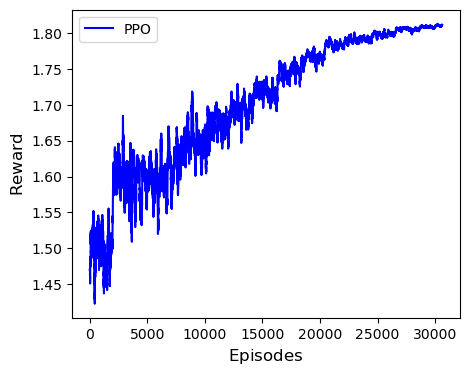

In [8]:
# Evaluate the agent
ppo_escaled_rewards = rescale_eposide_rewards(ppo_env.get_episode_rewards(), ppo_env.get_episode_lengths())
# moving average of results
ppo_average_results = rolling_average(ppo_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label="PPO", color='blue')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12) 
plt.legend()
#plt.ylim(ymax=1)
# save the plot
plt.savefig(os.path.join(images_path, f'ppo_reward_{numerical_id}.png'))

In [9]:
# Evaluate the trained agent
mean_ppo_reward, std_pp_reward = evaluate_policy(ppo_model, ppo_env)
print(f"mean_reward: {mean_ppo_reward:.4f} +/- {std_pp_reward:.4f}")

mean_reward: 1.8163 +/- 0.0002


In [10]:
# save the model
ppo_model.save(os.path.join(model_path, f'ppo_reward_{numerical_id}'))

### B. SAC

In [11]:
# Choose your algorithm
SAC_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
SAC_model = SAC("MlpPolicy", SAC_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
SAC_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 1.47     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 81       |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 1.55     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 1.54     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 82       |
|    time_elapsed    | 0      

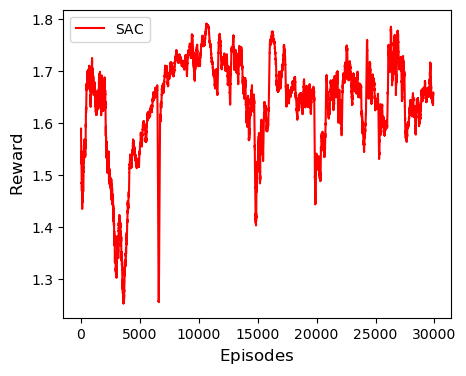

In [12]:
# Evaluate the agent
SAC_escaled_rewards = rescale_eposide_rewards(SAC_env.get_episode_rewards(), SAC_env.get_episode_lengths())
# moving average of results
SAC_average_results = rolling_average(SAC_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(SAC_average_results, label=r"$\rm SAC$", color='red')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12)
plt.legend()
# save the figure
plt.savefig(os.path.join(images_path, f'sac_reward_{numerical_id}.png'))


In [13]:
# Evaluate the trained agent
mean_SAC_reward, std_SAC_reward = evaluate_policy(SAC_model, SAC_env)
print(f"mean_reward: {mean_SAC_reward:.4f} +/- {std_SAC_reward:.4f}")

mean_reward: 1.7275 +/- 0.1496


In [14]:
# save the model
SAC_model.save(os.path.join(model_path, f'sac_reward_{numerical_id}'))

### C. A2C

In [15]:
# Choose your algorithm
A2C_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_function, reward_weight=reward_weight))
A2C_model = A2C("MlpPolicy", A2C_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
A2C_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 1.78     |
| time/                 |          |
|    fps                | 90       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -6.94    |
|    explained_variance | -0.0169  |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | 10.6     |
|    std                | 0.969    |
|    value_loss         | 2.58     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 1.8      |
| time/                 |          |
|    fps                | 89       |
|    iterations         | 200      |
|    time_elapsed      

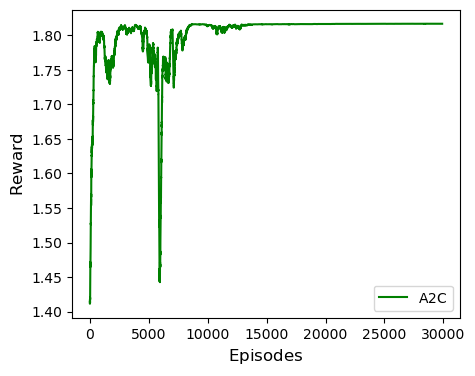

In [16]:
# Evaluate the agent
A2C_escaled_rewards = rescale_eposide_rewards(A2C_env.get_episode_rewards(), A2C_env.get_episode_lengths())
# moving average of results
A2C_average_results = rolling_average(A2C_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(A2C_average_results, label=r"$\rm A2C$", color='green')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Reward$", fontsize=12)
# plt.ylim(ymax=1)
plt.legend()
# save the figure
plt.savefig(os.path.join(images_path, f'a2c_reward_{numerical_id}.png'))

In [17]:
# Evaluate the trained agent
mean_A2C_reward, std_A2C_reward = evaluate_policy(A2C_model, A2C_env)
print(f"mean_reward: {mean_A2C_reward:.4f} +/- {std_A2C_reward:.4f}")

mean_reward: 1.8166 +/- 0.0000


In [18]:
# save the model
A2C_model.save(os.path.join(model_path, f'a2c_reward_{numerical_id}'))

## Compare

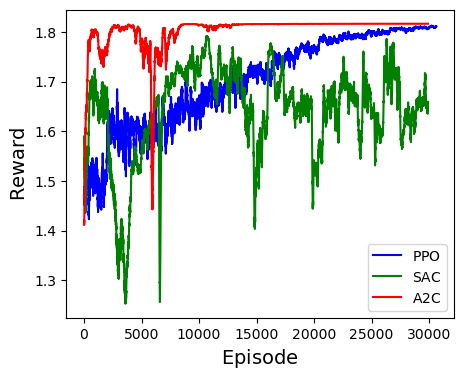

In [19]:
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label=r'$\rm PPO$', color='blue')
plt.plot(SAC_average_results, label=r'$\rm SAC$', color='green')
plt.plot(A2C_average_results, label=r'$\rm A2C$', color='red')
plt.xlabel(r'$\rm Episode$', fontsize=14)
plt.ylabel(r'$\rm Reward$', fontsize=14)
plt.legend()
plt.savefig(os.path.join(images_path, f'combined_reward_{numerical_id}.png'))

# Test controller

## A. PPO

In [20]:
ppo_action_recorder = test_controller(ppo_env, ppo_model, n_steps=10, id='ppo', reward_id=numerical_id, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [80.         2.        76.54016    1.3313816  0.3971256]
obs = [  0.9094371   0.9329533   3.0988154 100.87789  ]
reward = 1.8161417878645063
terminated =False
Step = 2
Action = [80.          2.         76.03182     1.3382545   0.39831883]
obs = [  0.90874124   0.92433727   3.1226263  100.679634  ]
reward = 1.8163075181844035
terminated =False
Step = 3
Action = [80.          2.         76.19607     1.3498275   0.40708604]
obs = [ 0.9083583   0.91965187  3.1357315  99.846176  ]
reward = 1.8163930600323752
terminated =False
Step = 4
Action = [80.         2.        76.69871    1.3322982  0.3992513]
obs = [  0.9096148   0.9336625   3.0927355 100.71827  ]
reward = 1.8162485556260006
terminated =False
Step = 5
Action = [80.         2.        75.65386    1.3570387  0.4124293]
obs = [ 0.9075712  0.910799   3.1626618 99.12212  ]
reward = 1.8164913071638717
terminated =False
Step = 6
Action = [80.         2.        76.3728     1.349177   0.4057704]
obs = [  0.90853256   0.921653

## B. SAC

In [21]:
SAC_action_recorder = test_controller(SAC_env, SAC_model, n_steps=10, id='sac', reward_id=numerical_id, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [79.          1.0044919  50.428474    0.2205924   0.13354404]
obs = [ 0.9521523  0.9077885  1.6372181 85.236855 ]
reward = 1.8613734481805546
terminated =False
Step = 2
Action = [ 22.           1.9781638  114.52717      1.0935186    0.46924847]
obs = [ 0.67826104  0.8154247  11.009032   75.92557   ]
reward = 1.5967185690706422
terminated =False
Step = 3
Action = [ 38.           1.1937337  111.49511      0.53746843   0.38814458]
obs = [ 0.85731834  0.8444868   4.8821783  72.599266  ]
reward = 1.7728696607886838
terminated =False
Step = 4
Action = [79.          1.7942983  57.143375    1.3618115   0.46362126]
obs = [ 0.8700034  0.6290859  4.4481297 86.17608  ]
reward = 1.8070948122475912
terminated =False
Step = 5
Action = [ 38.           1.9508331  110.5655       1.2053943    0.47861597]
obs = [ 0.83098495  0.99608105  5.7832346  88.56459   ]
reward = 1.7313768596821797
terminated =False
Step = 6
Action = [53.          1.9418933  81.61327     1.0460303   0.48169577]
obs

## C. A2C

In [22]:
A2C_action_recorder = test_controller(A2C_env, A2C_model, n_steps=10, id='a2c', reward_id=numerical_id, ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [80.      2.     87.4485  2.      0.5   ]
obs = [  0.8917636   0.7515643   3.703554  101.42116  ]
reward = 1.8166072053362003
terminated =False
Step = 2
Action = [80.       2.      87.24441  2.       0.5    ]
obs = [  0.89162135   0.7501248    3.7084217  101.3469    ]
reward = 1.816608894676425
terminated =False
Step = 3
Action = [80.        2.       87.384705  2.        0.5     ]
obs = [  0.8917192   0.7511145   3.7050748 101.39795  ]
reward = 1.8166077438392045
terminated =False
Step = 4
Action = [80.       2.      87.38545  2.       0.5    ]
obs = [  0.8917197    0.75111973   3.705057   101.398224  ]
reward = 1.816607737585686
terminated =False
Step = 5
Action = [80.       2.      87.42317  2.       0.5    ]
obs = [  0.891746     0.75138575   3.7041576  101.41194   ]
reward = 1.8166074202772708
terminated =False
Step = 6
Action = [80.      2.     87.4569  2.      0.5   ]
obs = [  0.89176947   0.7516236    3.7033536  101.42421   ]
reward = 1.816607133720412
terminat